# **Delivery Duration Prediction**

## Assignment
When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from

Start: the time consumer submits the order (created_at) to
End: when the order will be delivered to the consumer (actual_delivery_time)


## Data Description

The attached file historical_data.csv contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between created_at and actual_delivery_time.

 - Columns in historical_data.csv

**Time features**

- market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id

- created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer


**Store features**

- store_id: an id representing the restaurant the order was submitted for
- store_primary_category: cuisine category of the restaurant, e.g., italian, asian
- order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

**Order features**

- total_items: total number of items in the order
- subtotal: total value of the order submitted (in cents)
- num_distinct_items: number of distinct items included in the order
- min_item_price: price of the item with the least cost in the order (in cents)
- max_item_price: price of the item with the highest cost in the order (in cents)

**Market features**

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):

- total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation
- total_busy_dashers: Subset of above total_onshift_dashers who are currently working on an order
- total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

**Predictions from other models**

We have predictions from other models for various stages of delivery process that we can use:

- estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
- estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

**Practicalities**
Build a model to predict the total delivery duration seconds (as defined above). Feel free to generate additional features from the given data to improve model performance. Explain:

- model(s) used,
- how you evaluated your model performance on the historical data,
- any data processing you performed on the data,
- feature engineering choices you made,
- other information you would like to share your modeling approach.

- We expect the project to take 3-5 hours in total, but feel free to spend as much time as you like on it. Feel free to use any open source packages for the task.


#### To download the dataset <a href="https://drive.google.com/drive/folders/1H4wDwJhfElUd4OfkaoH_VIZhvwDuOMxf?usp=sharing"> Click here </a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('historical_data.csv')

In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [5]:
# converting to timedelta 
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')

In [6]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [7]:
# adding new column to see time taken by delivery man to deliver product.
df['time_taken'] = df['actual_delivery_time']-df['created_at']
df['time_taken'] = df['time_taken'].astype(str).str.replace('0 days ', '').str.strip()

#converting to timezone for analysis
df['time_taken'] = pd.to_timedelta(df['time_taken'])

# converting to time taken to place order in seconds
df['time_taken_seconds'] = df['time_taken'].dt.total_seconds()

#removing time_taken from the dataset for further analysis
df.drop('time_taken', axis=1, inplace=True)

In [8]:
df.describe()

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,time_taken_seconds
count,196441.000000,197428,197421,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,1.974210e+05
mean,2.978706,2015-02-04 22:00:09.537962752,2015-02-04 22:48:23.348914432,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935,2.908257e+03
min,1.000000,2014-10-19 05:24:15,2015-01-21 15:58:11,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,1.010000e+02
25%,2.000000,2015-01-29 02:32:42,2015-01-29 03:22:29,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,2.104000e+03
50%,3.000000,2015-02-05 03:29:09.500000,2015-02-05 04:40:41,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,2.660000e+03
75%,4.000000,2015-02-12 01:39:18.500000,2015-02-12 02:25:26,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,3.381000e+03
max,6.000000,2015-02-18 06:00:44,2015-02-19 22:45:31,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,8.516859e+06
std,1.524867,NaN,NaN,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902,1.922961e+04


In [9]:
#missing values
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
time_taken_seconds                                  7
dtype: int64

In [10]:
# using simple Imputer to fill NaN values in dataset
from sklearn.impute import SimpleImputer

imputer_numeric = SimpleImputer(strategy='mean')
imputer_categorical = SimpleImputer(strategy='most_frequent')

numeric = df.select_dtypes(include=['int64', 'float64']).columns
categorical = df.select_dtypes(include=['object']).columns

df[numeric] = imputer_numeric.fit_transform(df[numeric])
df[categorical] = imputer_categorical.fit_transform(df[categorical])

#filling NaN value in date column 
df['actual_delivery_time'] = df['actual_delivery_time'].fillna(df['actual_delivery_time'].mode()[0])
df['time_taken_seconds'] = df['time_taken_seconds'].fillna(df['time_taken_seconds'].mean())


In [11]:
#filling nan in categorical column
df['store_primary_category'] = df['store_primary_category'].fillna(df['store_primary_category'].mode()[0])
df['store_primary_category'] = df['store_primary_category'].fillna('Unknown')
df['store_primary_category'].dropna(inplace=True)

## EDA

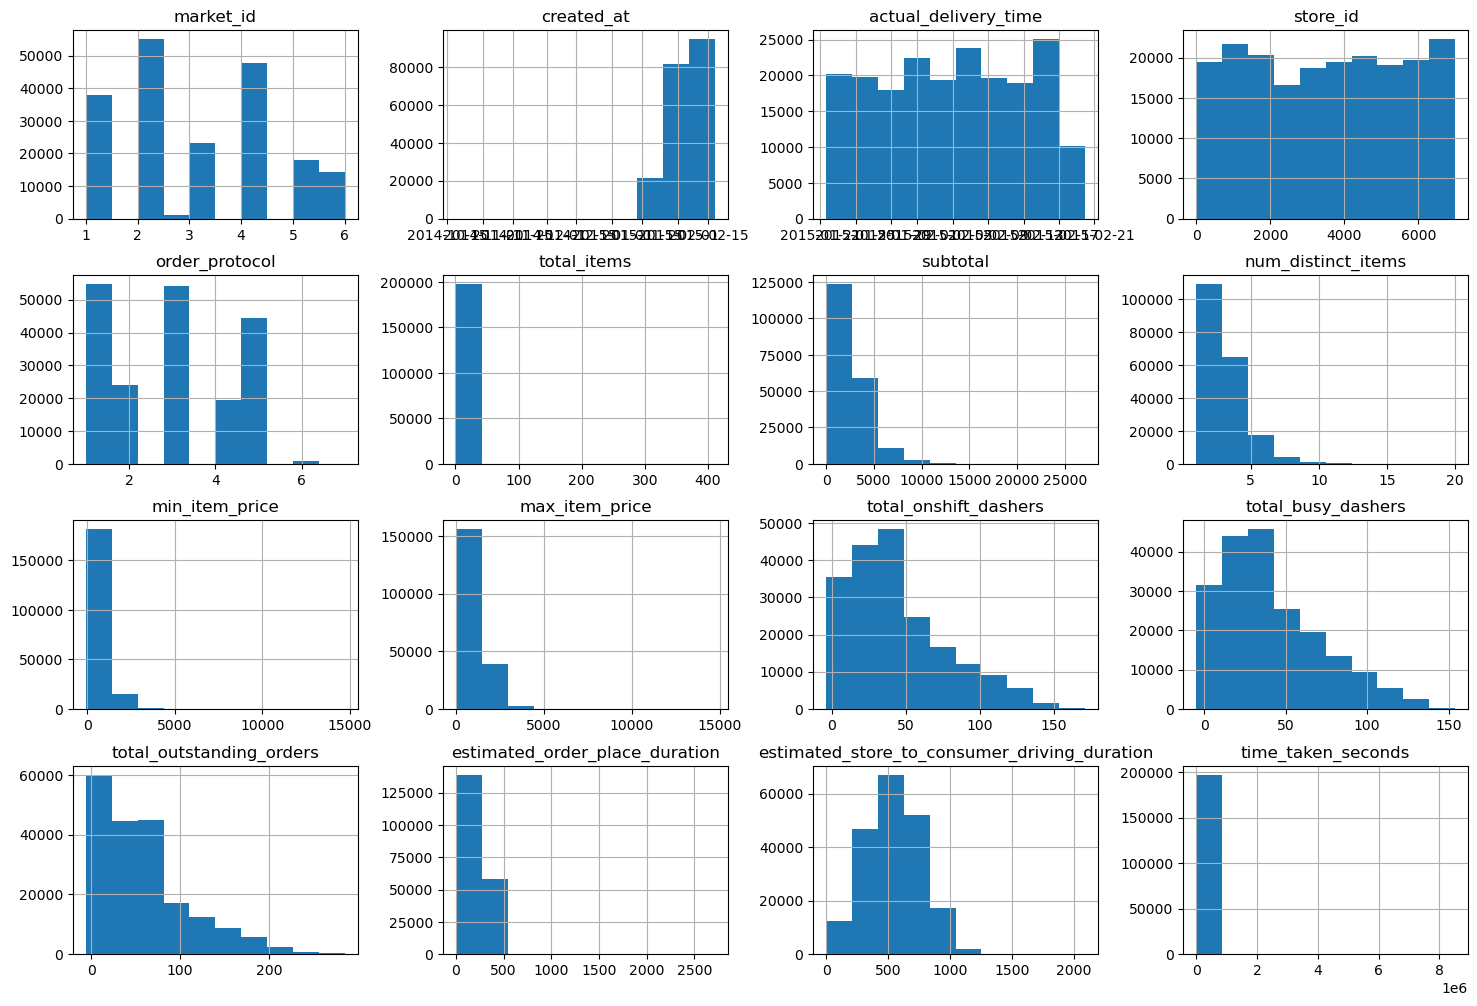

In [12]:
df.hist(figsize=(18,12))
plt.show()

## Outliers

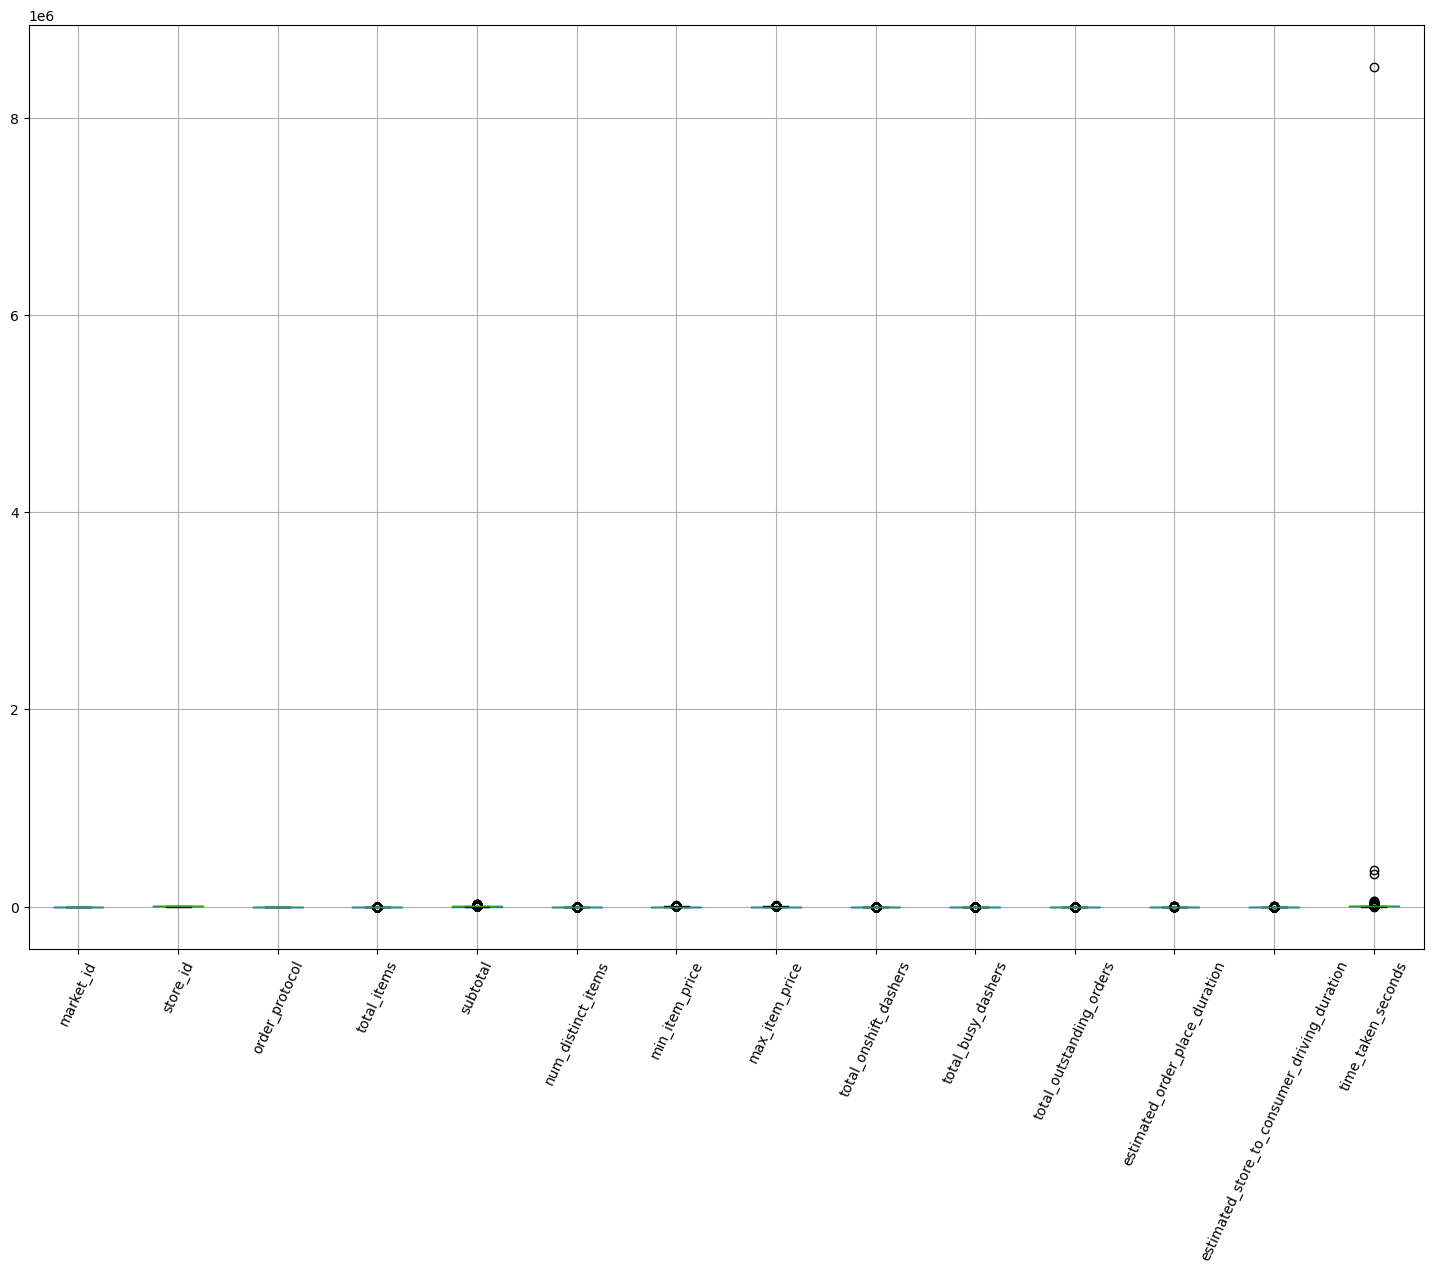

In [13]:
df.boxplot(figsize=(18,12))
plt.xticks(rotation=65)
plt.show()

In [14]:
def outliers_lims(col):
    q3, q1 = np.percentile(col, [75, 25])
    iqr = q3 - q1
    upper_lims = q3 + 1.5*iqr
    lower_lims = q1 - 1.5*iqr
    return upper_lims, lower_lims

In [15]:
for col in df.select_dtypes(include=['int64', 'float64', 'datetime64']):
    print('------------------------------------\n')
    print('Columns - ', col)
    UL, LL = outliers_lims(df[col])

    print('Under Limit = ', UL)
    print('Lower Limit = ', LL)

    total_outliers = len(df.loc[df[col]<LL, col]) + len(df.loc[df[col]>UL, col])
    percentage = (total_outliers/len(df.index))*100

    print('Percentage of Outliers= ', percentage)
    print('------------------------------------------- \n')

------------------------------------

Columns -  market_id
Under Limit =  7.0
Lower Limit =  -1.0
Percentage of Outliers=  0.0
------------------------------------------- 

------------------------------------

Columns -  created_at
Under Limit =  2015-03-05T00:19:13.250000000
Lower Limit =  2015-01-08T03:52:47.250000000
Percentage of Outliers=  0.0005065137670441883
------------------------------------------- 

------------------------------------

Columns -  actual_delivery_time
Under Limit =  2015-03-05T00:59:53.375000000
Lower Limit =  2015-01-08T04:47:38.375000000
Percentage of Outliers=  0.0
------------------------------------------- 

------------------------------------

Columns -  store_id
Under Limit =  10718.5
Lower Limit =  -3733.5
Percentage of Outliers=  0.0
------------------------------------------- 

------------------------------------

Columns -  order_protocol
Under Limit =  8.5
Lower Limit =  -3.5
Percentage of Outliers=  0.0
--------------------------------------

In [16]:
outliers_col = ['created_at', 'total_items', 'subtotal', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'time_taken_seconds']

for col in outliers_col:
    UL, LL = outliers_lims(df[col])
    df.loc[df[col]<LL, col] = np.nan
    df.loc[df[col]>UL, col] = np.nan

df.dropna(subset=['created_at', 'total_items', 'subtotal', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'time_taken_seconds'], inplace=True)
df.reset_index(drop=True, inplace=True)

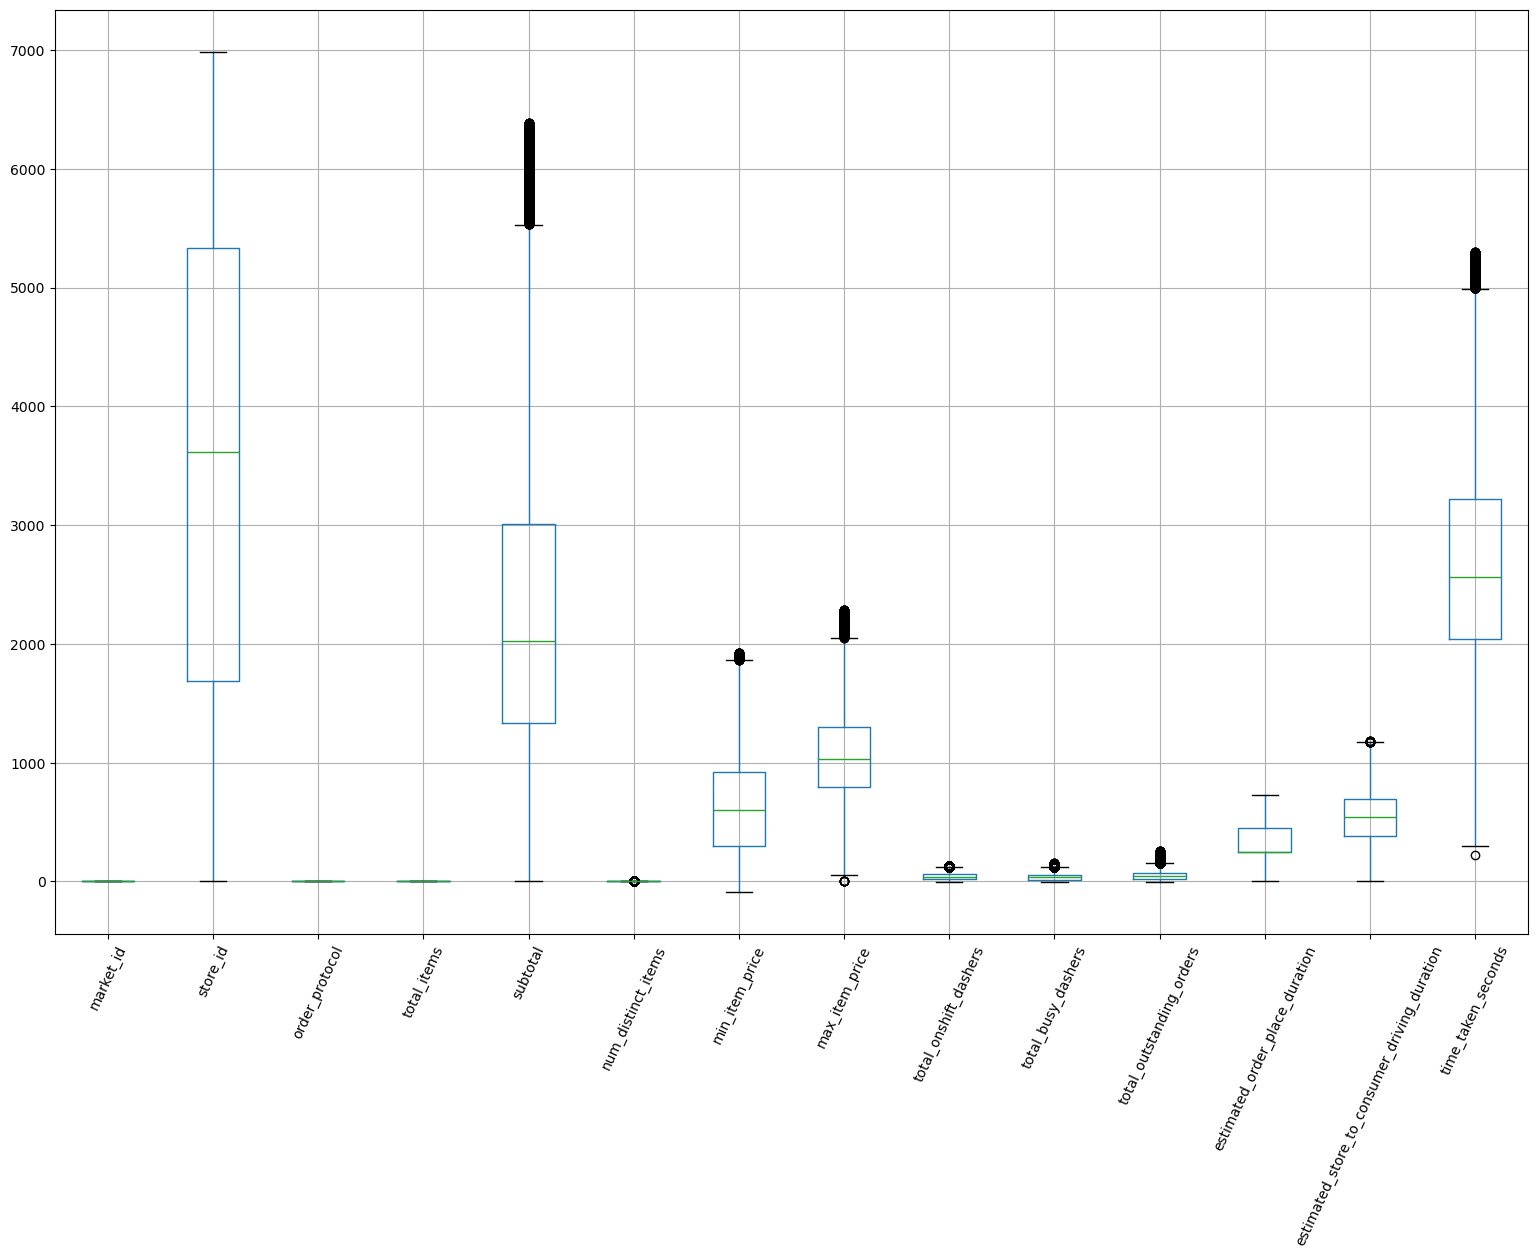

In [17]:
df.boxplot(figsize=(19, 12))
plt.xticks(rotation=65)
plt.show()

## Coorelation

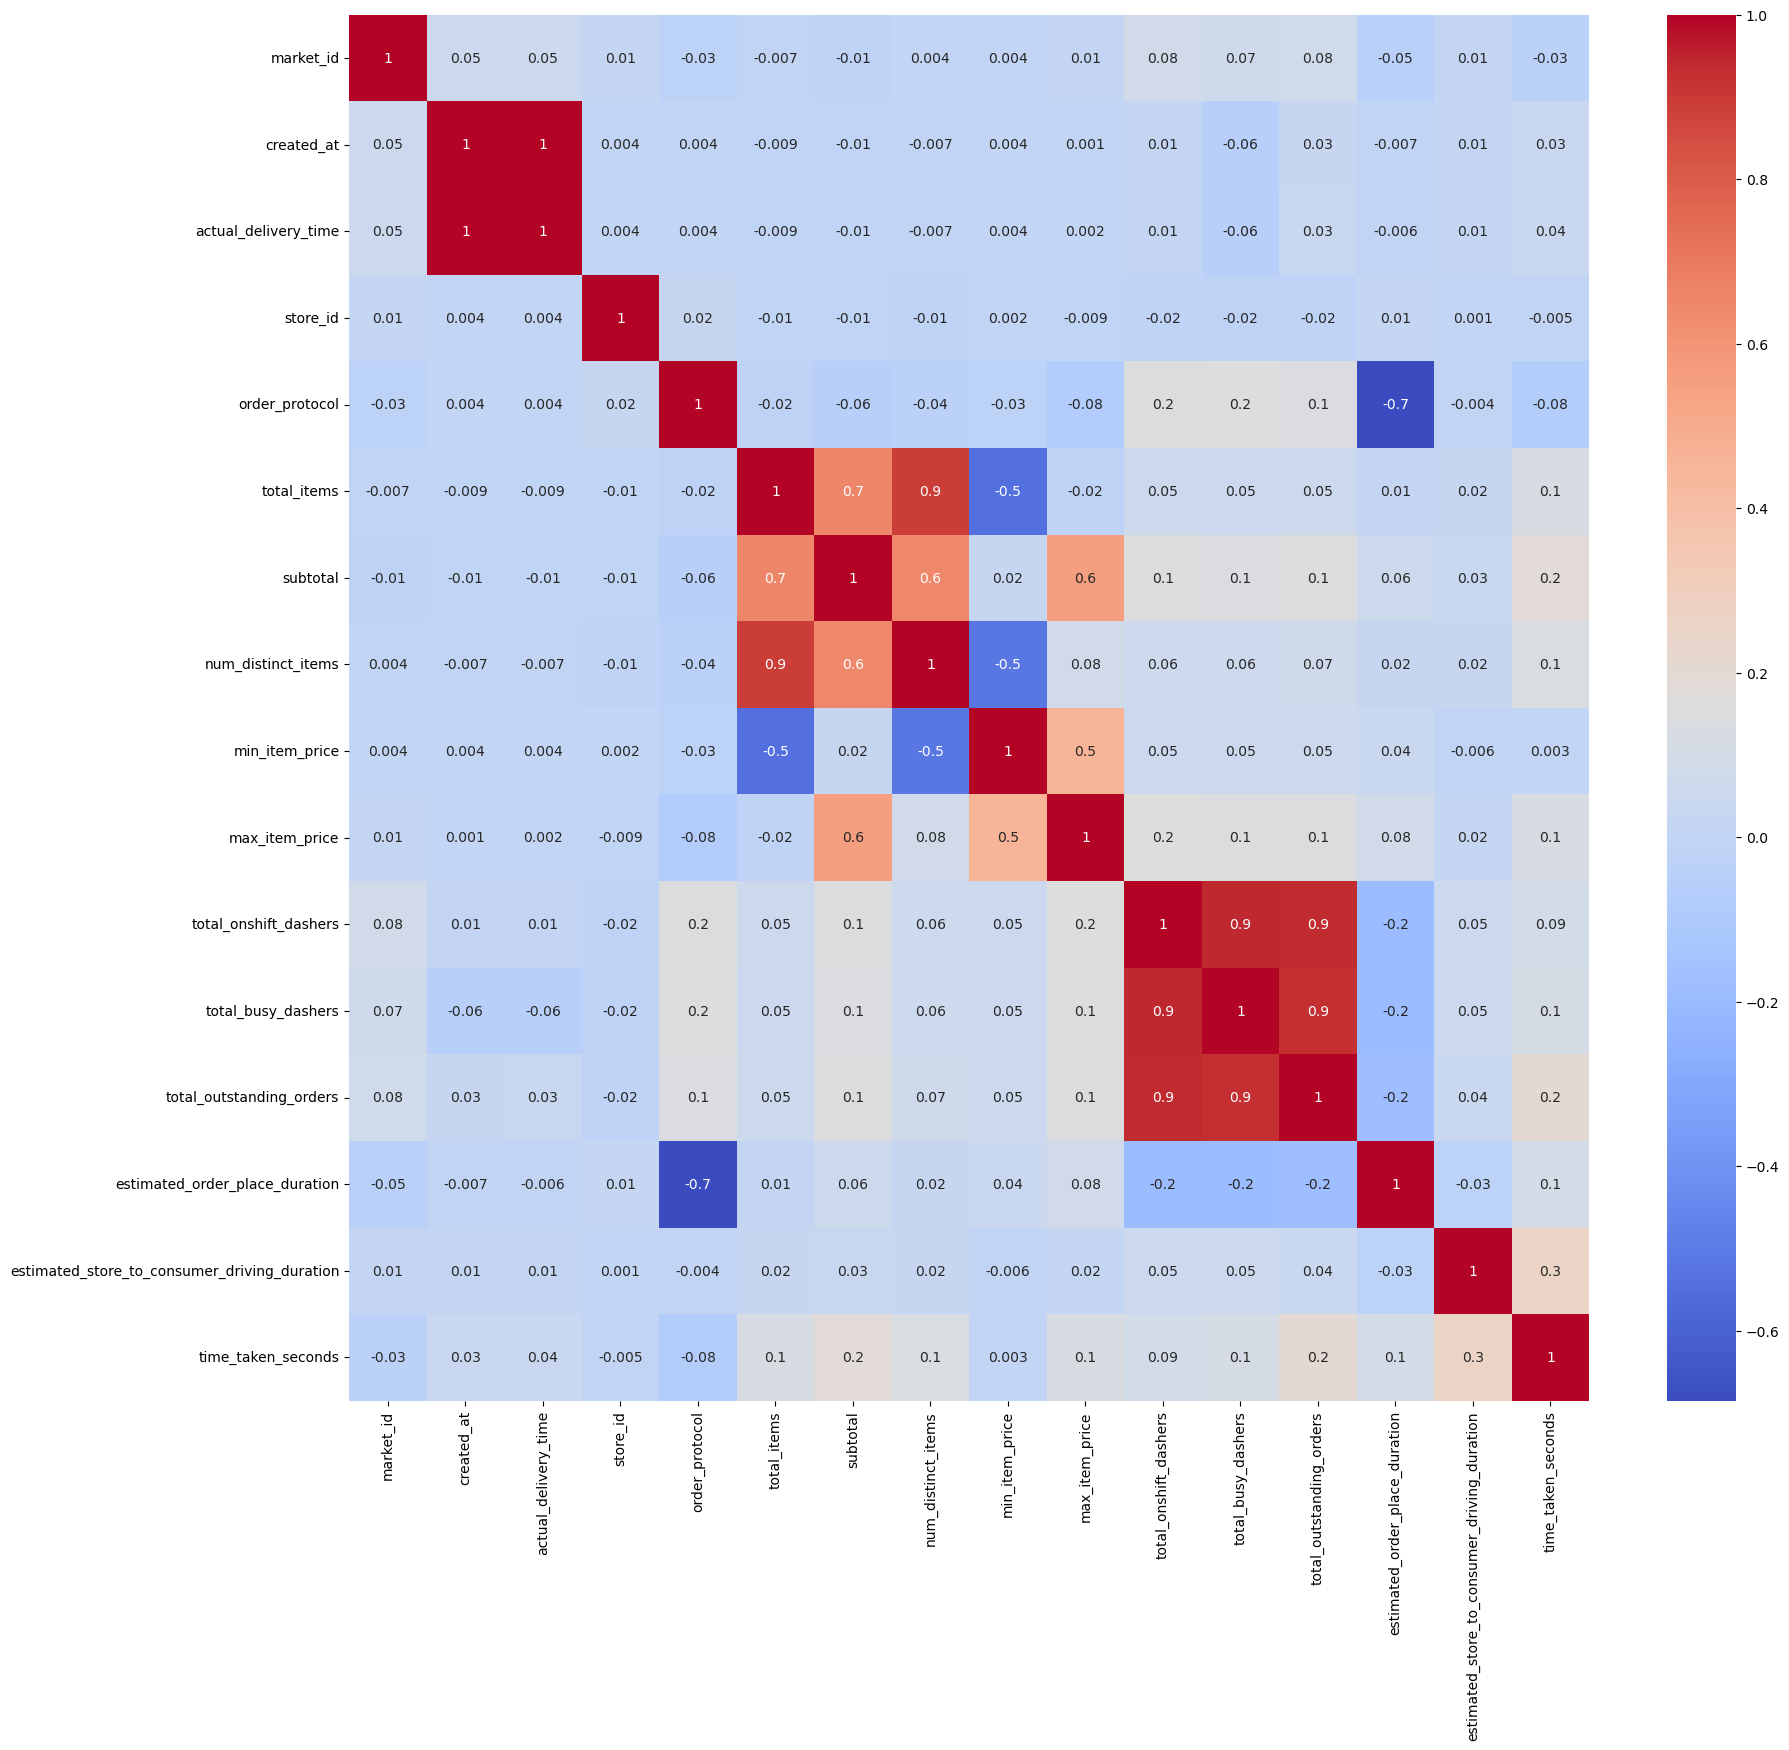

In [18]:
df_corr = df.select_dtypes(include=['int64', 'float64', 'datetime64']).corr()
plt.figure(figsize=(20, 18))
sns.heatmap(data=df_corr, annot=True, fmt='.1g', cmap='coolwarm')
plt.show()

In [19]:
feature_correlation = set()

# removing independent columns from dataset
for i in range(len(df_corr.columns)):
    for j in range(i):
        if abs(df_corr.iloc[i, j]) >= 0.7:
            column_name = df_corr.columns[i]
            feature_correlation.add(column_name)

df.drop(columns=feature_correlation, inplace=True)

print(feature_correlation)

{'total_outstanding_orders', 'actual_delivery_time', 'total_busy_dashers', 'num_distinct_items'}


## Stander Scaler

In [32]:
data = df.copy()

data['created_at'] = data['created_at'].astype('int64') // 10**9

In [35]:
from sklearn.preprocessing import StandardScaler

data_col = data.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

data[data_col] = scaler.fit_transform(data[data_col])


## Label Encoding

In [36]:
from sklearn.preprocessing import LabelEncoder

categorical_col = 'store_primary_category'

encode = LabelEncoder() 
data[categorical_col] = encode.fit_transform(data[categorical_col].astype(str))

## Correlation with target variable

X = data.drop('time_taken_seconds', axis=1)
X.corrwith(data['time_taken_seconds']).plot.bar(figsize=(18,12), title='Correlation with tartget variable', fontsize=20, grid=True, rot=90)

## train test split

In [37]:
from sklearn.model_selection import train_test_split

X = data.drop('time_taken_seconds', axis=1)
y = data['time_taken_seconds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=101)

In [38]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (116221, 12)
y_train (116221,)
X_test (49809, 12)
y_test (49809,)



Linear Regressor Performance:
Mean Absolute Error: 0.7514
Mean Squared Error: 0.8870
R2 Score: 0.1169


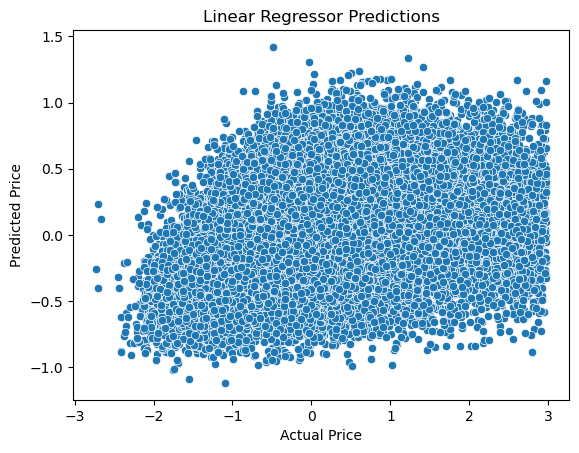


Random Forest Regressor Performance:
Mean Absolute Error: 0.7072
Mean Squared Error: 0.7870
R2 Score: 0.2164


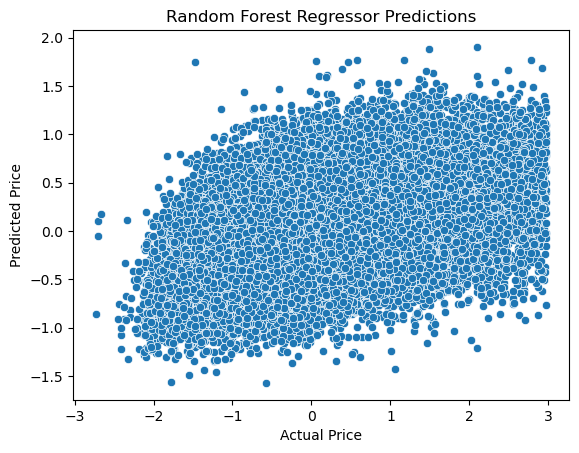


Gradient Boosting Regressor Performance:
Mean Absolute Error: 0.7059
Mean Squared Error: 0.7838
R2 Score: 0.2196


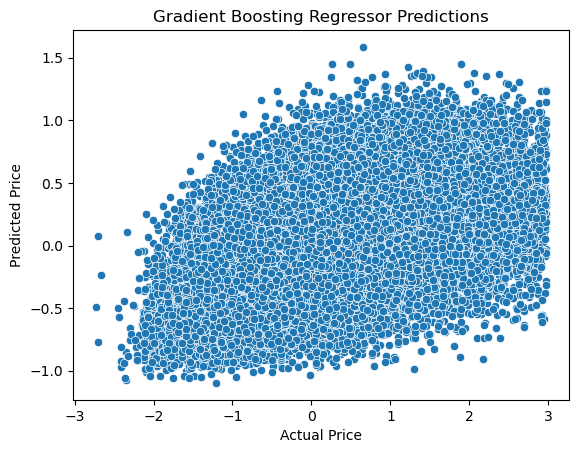


Final Model Performance:
Mean Absolute Error: 0.7075
Mean Squared Error: 0.7873
R2 Score: 0.2161


In [40]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    'Linear Regressor': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=43),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=40)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Performance:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{name} Predictions")
    plt.show()

# Choosing the best model based on R2 score
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_final_pred = best_model.predict(X_test)

# Final Model Evaluation
print("\nFinal Model Performance:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_final_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_final_pred):.4f}")
print(f"R2 Score: {r2_score(y_test, y_final_pred):.4f}")


## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning for Random Forest Regressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and model training
best_params = grid_search.best_params_
print("\nBest Hyperparameters:", best_params)

best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_final_pred = best_model.predict(X_test)

# Final Model Evaluation
print("\nFinal Tuned Model Performance:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_final_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_final_pred):.4f}")
print(f"R2 Score: {r2_score(y_test, y_final_pred):.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
